## BLR AI Academy - Logistic Regression Hands on


In this hands on, we'll implement binary logistic regression from scratch. Logistic regression is a generalized linear model that we can use to model or predict categorical outcome variables. We might use logistic regression to predict whether someone will be denied or approved for a loan, but probably not to predict the value of someone's house.

In logistic regression, we're essentially trying to find the weights that maximize the likelihood of producing our given data. Since this maximizing the likelihood is an iterative process, we'll solve the optimization problem with gradient descent. 

Let's get started. First we need to load the data


In [0]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import math

from scipy.sparse import csr_matrix, coo_matrix, find, hstack
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize, OneHotEncoder, LabelEncoder, MinMaxScaler, MaxAbsScaler, StandardScaler
#from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split

## Load the data

We'll use dataset available at: https://archive.ics.uci.edu/ml/datasets/Census+Income

#### Task: Predict whether income exceeds $50K/yr based on census data


#### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 

Prediction task is to determine whether a person makes over 50K a year.


<br>

#### Attributes Information:

#### Label:  
 
  - ''>50K", "<=50K". 



#### Features:

age: continuous. 

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

fnlwgt: continuous. 

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

education-num: continuous. 

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-

inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

sex: Female, Male. 

capital-gain: continuous. 

capital-loss: continuous. 

hours-per-week: continuous. 

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [0]:
# We'll load the 1997 Census data

df = pd.read_csv(r'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 names=['age', 'workclass','fnlwgt','education', 'ednum','maritalstatus', 'occupation','relationship',
                        'race','sex','capitalgain','capitalloss','hoursperweek','nativecountry','income'])

print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,ednum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
df.describe()

,age,fnlwgt,ednum,capitalgain,capitalloss,hoursperweek
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Missing Values

In [0]:
# Let's see which features have missing values

# print(df.dtypes)

# for i,j in zip(df.columns,(df.values.astype(str) == "?").sum(axis = 0)):
#   if j > 0:
#     print(str(i) + ': ' + str(j) + ' records')


In [0]:
df.income.unique()

array([' <=50K', ' >50K'], dtype=object)

## Let's look at variables wr.t. the label and plot some of them

Text(0, 0.5, 'Proportion of population')

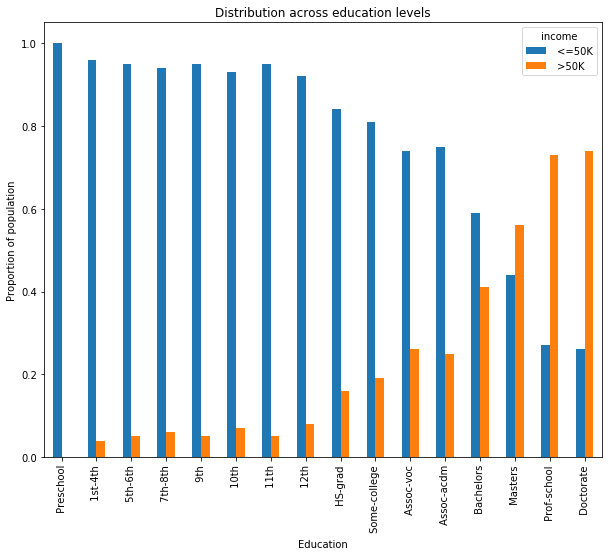

In [0]:
edu_level = {}
dfc = df.copy()
for x,y in dfc[['ednum','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x
    
education = round(pd.crosstab(dfc.education, dfc.income).div(pd.crosstab(dfc.education, dfc.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education')
ax.set_ylabel('Proportion of population')


## Question:

Plot other variables like Gender, Occupation, Age w.r.t. Label (income)

## Convert Label column to binary

In [0]:
df['binaryincome'] = df['income'].apply(lambda x: 0 if x == df.income.iloc[0] else 1)

df = df.drop(columns = ['income'])
df.head()

,age,workclass,fnlwgt,education,ednum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,binaryincome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Label, Categorical and Numerical Features


In [0]:
label_feature = 'binaryincome'
features = df.columns.to_list()[:]
features.remove(label_feature)
cat_features = list(set(features) - set(df.describe().columns))
num_features = list(set(features) - set(cat_features)) 

cat_features, num_features


(['occupation',
  'education',
  'relationship',
  'race',
  'maritalstatus',
  'workclass',
  'nativecountry',
  'sex'],
 ['ednum', 'capitalgain', 'hoursperweek', 'fnlwgt', 'capitalloss', 'age'])

## Prepare Data for Training and Testing

Convert categorical to one hot encoding

In [0]:
df_cat_1hot = pd.get_dummies(df[cat_features])
df_non_cat = df[num_features]

df_prepped = pd.concat([df_non_cat, df_cat_1hot], axis=1, join='inner')
df_label = df.binaryincome
#df_label = df[['binaryincome']]

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_prepped, df_label, test_size = .3, random_state=42, stratify=df_label)
#df_train = X_train_raw.merge(y_train_raw.to_frame(), left_index=True, right_index=True)
#df_test = X_test_raw.merge(y_test_raw.to_frame(), left_index=True, right_index=True)

In [0]:
print(df_prepped.shape)
df_prepped.head()

(32561, 108)


,ednum,capitalgain,hoursperweek,fnlwgt,capitalloss,age,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,nativecountry_ Columbia,nativecountry_ Cuba,nativecountry_ Dominican-Republic,nativecountry_ Ecuador,nativecountry_ El-Salvador,nativecountry_ England,nativecountry_ France,nativecountry_ Germany,nativecountry_ Greece,nativecountry_ Guatemala,nativecountry_ Haiti,nativecountry_ Holand-Netherlands,nativecountry_ Honduras,nativecountry_ Hong,nativecountry_ Hungary,nativecountry_ India,nativecountry_ Iran,nativecountry_ Ireland,nativecountry_ Italy,nativecountry_ Jamaica,nativecountry_ Japan,nativecountry_ Laos,nativecountry_ Mexico,nativecountry_ Nicaragua,nativecountry_ Outlying-US(Guam-USVI-etc),nativecountry_ Peru,nativecountry_ Philippines,nativecountry_ Poland,nativecountry_ Portugal,nativecountry_ Puerto-Rico,nativecountry_ Scotland,nativecountry_ South,nativecountry_ Taiwan,nativecountry_ Thailand,nativecountry_ Trinadad&Tobago,nativecountry_ United-States,nativecountry_ Vietnam,nativecountry_ Yugoslavia,sex_ Female,sex_ Male
0,13,2174,40,77516,0,39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,13,0,13,83311,0,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9,0,40,215646,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,7,0,40,234721,0,53,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,13,0,40,338409,0,28,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
print(df_label.shape)
df_label.head()

(32561,)


0    0
1    0
2    0
3    0
4    0
Name: binaryincome, dtype: int64

In [0]:
print(df_train_x.shape)
print(df_test_x.shape)
print(df_train_y.shape)
print(df_test_y.shape)
print(df_train_x.head())
print(df_train_y.head())

(22792, 108)
(9769, 108)
(22792,)
(9769,)
       ednum  capitalgain  ...  sex_ Female  sex_ Male
24029      7            0  ...            0          1
8788      10            0  ...            1          0
15564     10            0  ...            1          0
9585       6            0  ...            1          0
7377      10            0  ...            1          0

[5 rows x 108 columns]
24029    0
8788     0
15564    0
9585     0
7377     1
Name: binaryincome, dtype: int64



## Selecting the Link Function

Generalized linear models usually tranform a linear model of the predictors by using a link function. In logistic regression, the link function is the sigmoid. We can implement this really easily.


In [0]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))


## Maximizing the Likelihood

To maximize the likelihood, we need to compute the likelihood and the gradient of the likelihood. Fortunately, the likelihood (for binary classification) can be reduced to a fairly intuitive form by switching to the log-likelihood. We're able to do this without affecting the weights parameter estimation because log transformation are monotonic.

Check out Section 4.4.1 of Hastie, Tibsharani, and Friedman's Elements of Statistical Learning for derivations of the functions. 

Calculating the Log-Likelihood:

$$\begin{equation} ll(\beta) = \sum_{i=1}^{N}y_{i}log(1/(1+e^{-\beta^{T}x_{i}}))  + (1-y_{i}) log(1- 1/(1+e^{-\beta^{T}x_{i}})) \end{equation}$$

$$\begin{equation} ll(\beta) = \sum_{i=1}^{N}y_{i}\beta ^{T}x_{i} - log(1+e^{\beta^{T}x_{i}}) \end{equation}$$

where $y$ is the target class, $x_{i}$ represents an individual data point, and $\beta$ is the weights vector.



In [0]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll


## Calculating the Gradient

Now I need an equation for the gradient of the log-likelihood. By taking the derivative of the equation above and reformulating in matrix form, the gradient becomes:
$$\begin{equation} \bigtriangledown ll = X^{T}(Y - Predictions) \end{equation}$$

Again, this is really easy to implement. It's so simple I don't even need to wrap it into a function. The gradient here looks very similar to the output layer gradient in a neural network (see my post on neural networks if you're curious).

This shouldn't be too surprising, since a neural network is basically just a series of non-linear link functions applied after linear manipulations of the input data.



## Building the Logistic Regression Function

Finally, I'm ready to build the model function. I'll add in the option to calculate the model with an intercept, since it's a good option to have.


In [0]:
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
  if add_intercept:
    intercept = np.ones((features.shape[0], 1))
    features = np.hstack((intercept, features))
        
  weights = np.zeros(features.shape[1])
    
  for step in iter(range(num_steps)):
    scores = np.dot(features, weights)
    predictions = sigmoid(scores)

    # Update weights with log likelihood gradient
    output_error_signal = target - predictions

    gradient = np.dot(features.T, output_error_signal)
    weights += learning_rate * gradient

    # Print log-likelihood every so often
    if step % 1000 == 0:
      print(log_likelihood(features, target, weights))

  return weights

In [0]:
weights = logistic_regression(df_train_x, df_train_y, num_steps = 1, learning_rate = 0.001, add_intercept=True)

-1171182172287710.0


(10000,)

In [0]:
print(weights)

[-6.74400000e+00 -2.58370000e+01  7.24040550e+04 -1.35838000e+02
 -1.34900889e+06  2.21199300e+03 -1.05487000e+02 -1.26650000e+00
 -2.26000000e+00 -9.00000000e-03 -1.08800000e+00  2.64000000e+00
 -5.88000000e-01 -1.15150000e+00 -1.24350000e+00 -2.88550000e+00
 -1.69000000e-01  2.22650000e+00  6.60000000e-02 -4.78000000e-01
  2.45000000e-02 -5.62000000e-01 -7.41500000e-01 -1.02600000e+00
 -3.50500000e-01 -1.64500000e-01 -3.21000000e-01 -5.29500000e-01
 -4.49500000e-01 -2.56000000e-01 -2.59000000e-01  2.19550000e+00
  6.43000000e-01 -5.05050000e+00  1.54600000e+00 -5.25000000e-02
  8.98000000e-01 -2.82600000e+00  6.85350000e+00 -5.69050000e+00
 -9.45000000e-01 -5.09400000e+00 -2.80400000e+00  9.36000000e-01
 -1.86500000e-01 -1.34000000e-01 -1.94550000e+00 -2.12000000e-01
 -4.26600000e+00 -3.08150000e+00  8.00000000e-03  7.65300000e+00
 -3.22000000e-01 -9.39600000e+00 -8.72500000e-01 -7.33000000e-01
 -1.25750000e+00  2.92500000e-01 -3.70000000e-02 -9.00000000e-03
 -6.58000000e+00  1.02000


## Comparing with Sklearn's LogisticRegression

How do I know if my algorithm spit out the right weights? Well, one the one hand, the math looks right -- so I should be confident it's correct.

Fortunately, I can compare my functions' weights to the weights from sk-learn's logistic regression function, which is known to be a correct implementation. They should be the same if I did everything correctly. Since sk-learn's LogisticRegression automatically regularizes (which I didn't do), I set C=1e15 to essentially turn off regularization.


In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, C = 0.001)
clf.fit(df_train_x, df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#print(clf.intercept_, clf.coef_)
print(clf.coef_)

[[-2.01349900e-03  3.43133531e-04 -9.76460941e-03 -3.72746286e-06
   7.52273280e-04 -5.18727525e-03 -4.33763642e-04 -7.02481717e-04
  -2.72300227e-06 -2.21523205e-04  1.01994879e-03 -2.03554180e-04
  -3.71698913e-04 -3.66632451e-04 -9.62272987e-04 -5.49680141e-05
   8.25624941e-04  6.88981711e-05 -1.02271203e-04  4.09800303e-05
  -1.41283300e-04 -2.37784455e-04 -3.50123982e-04 -1.18275597e-04
  -4.40726745e-05 -9.01700295e-05 -1.71651266e-04 -1.38126332e-04
  -5.91256343e-05 -5.91487894e-05  9.13252059e-04  2.29373032e-04
  -1.46311293e-03  5.53519942e-04 -1.69361268e-05  2.70624773e-04
  -8.25962675e-04  3.00001563e-03 -1.94552096e-03 -3.10871019e-04
  -1.80895889e-03 -9.21847326e-04  3.79461880e-04 -8.78876892e-05
  -5.35079431e-05 -5.17628129e-04 -6.56163071e-05 -8.83080615e-04
  -1.00494807e-03  4.91240975e-06  3.33274076e-03 -1.11366145e-04
  -3.30015644e-03 -2.77024605e-04 -2.51878591e-04 -4.30820984e-04
   1.52014441e-04  6.06408516e-05 -2.94265756e-06 -1.72657382e-03
   3.39516

As expected, my weights nearly perfectly match the sk-learn LogisticRegression weights. If I trained the algorithm longer and with a small enough learning rate, they would eventually match exactly. Why? Because gradient descent on a convex function will always reach the global optimum, given enough time and sufficiently small learning rate.


## Let's go over some metrics 

To get the accuracy, I just need to use the final weights to get the logits for the dataset (final_scores). Then I can use sigmoid to get the final predictions and round them to the nearest integer (0 or 1) to get the predicted class.


In [0]:
final_scores = np.dot(np.hstack((np.ones((df_test_x.shape[0], 1)),
                                 df_test_x)), weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy from scratch: {0}'.format((preds == df_test_y).sum().astype(float) / len(preds)))
print('Accuracy from sk-learn: {0}'.format(clf.score(df_test_x, df_test_y)))

Accuracy from scratch: 0.7592384072064694
Accuracy from sk-learn: 0.7963967652779199


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [0]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc[1,1]
    TN = confusion.loc[0,0]
    FP = confusion.loc[0,1]
    FN = confusion.loc[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

In [0]:
print("From scratch:")
logistic_reg = model_eval(df_test_y, preds)
print('Accuracy : %.2f percent'  % (round(logistic_reg['accuracy']*100,3)))
print('Precision : %.2f percent' % (round(logistic_reg['precision']*100,3)))
print('Recall : %.2f percent' % (round(logistic_reg['recall']*100,3)))
print('F1 Score : %.2f percent' % (round(logistic_reg['f_measure']*100,3)))

print()

print("From sklearn:")
logistic_reg = model_eval(df_test_y, clf.predict(df_test_x))
print('Accuracy : %.2f percent'  % (round(logistic_reg['accuracy']*100,3)))
print('Precision : %.2f percent' % (round(logistic_reg['precision']*100,3)))
print('Recall : %.2f percent' % (round(logistic_reg['recall']*100,3)))
print('F1 Score : %.2f percent' % (round(logistic_reg['f_measure']*100,3)))

From scratch:
Accuracy : 79.12 percent
Precision : 81.84 percent
Recall : 17.05 percent
F1 Score : 28.22 percent

From sklearn:
Accuracy : 79.64 percent
Precision : 70.60 percent
Recall : 26.45 percent
F1 Score : 38.48 percent


In [0]:
def rocauc(y_true, y_score):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    return roc_auc_score(y_true, y_score)
  
print(rocauc(df_test_y, preds))
print(rocauc(df_test_y, clf.predict(df_test_x)))

0.5792468682902582
0.6147680017132915


## Question:

Print the train metrics and compare with test for each LR implementation

## Plottting curves

In [0]:

def plot_pr_curve(y_true, y_score, label = None, color = None):
    precision, recall, test_threshold = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, label = label, color = color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    

def plot_roc_curve(y_true, y_score, label = None, color = None):
    fpr, tpr, test_threshold = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label = label, color = color)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

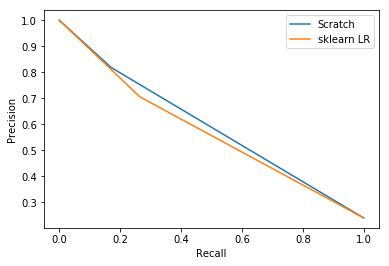

In [0]:
plot_pr_curve(df_test_y, preds, label='Scratch')
plot_pr_curve(df_test_y, clf.predict(df_test_x), label='sklearn LR')

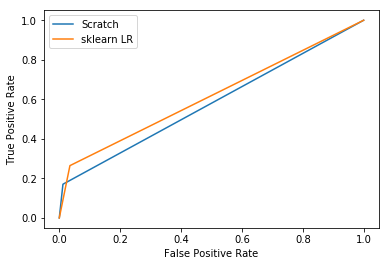

In [0]:
plot_roc_curve(df_test_y, preds, label='Scratch')
plot_roc_curve(df_test_y, clf.predict(df_test_x), label='sklearn LR')

# Questions and follow-up tasks:


### 1. How do these metrics relate to Business Requirements? At what threshold are Precision and Recall calculated? Can we change the threshold to have better recall?

### 2. See how *class imbalance* affects train, test performance

### 3. Add k fold cross validation and *regularization* to the above and compare how the test error changes

### 4. Add different splits of train test - stratified vs randomized splits and compare results

### 5. Plot feature importance based on coefficient values

### 6. Plot correlation among features to see if there are any redundant features, and compare how model assigns weights to them

### 7. Plot correlation of features with label to see if the ones with high correlation got a high weight by the model

### 8. Try other algorithms - Random Forest, Gradient Boosted Trees, SVMs (sklearn library) and compare results

### 9. Implement distributed Logistic Regression - using other libraries, and/or on Spark/Hadoop

### 10. Are the features good? Is including Age / Gender / Race a good idea to train models on? Will this result in a biased model? Is it a good practice to include societal biases in models? If not, how to avoid them? Will mitigating them affect metrics?

### 11. What are some baselines to compare this LR implementation against?

### 12. Make Y a polynomial function of X and see how train and test results are in LR

### 13. This notebook looks at Binary Classification where income is divided into 2 buckets: <=50K and >50K, can we extend this to Multiclass Classification? What if we had more buckets: <=20K, (20K-40K], (40K-60K], (60K-80K], >80K 


## Acknowledgement


Material adapted from:
- https://github.com/beckernick/logistic_regression_from_scratch/blob/master/logistic_regression_scratch.ipynb
